# Simple Reinforcement Learning in Tensorflow Part 1.5: The Contextual Bandits

In this iPython notebook we implement a policy-gradient based agent that can solve the contextual bandit problem using pyTorch. For more details see original tutorial containing tensorflow code on [Medium](https://medium.com/p/bff01d1aad9c).

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

### The Contextual Bandits
Here we define our contextual bandits. In this example, we are using three four-armed bandit. What this means is that each bandit has four arms that can be pulled. Each bandit has different success probabilities for each arm, and as such requires different actions to obtain the best result. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit-arm that will most often give a positive reward, depending on the Bandit presented.

In [2]:
class contextual_bandit():
    def __init__(self):
        self.state = 0
        # List out our bandits. Currently arms 4, 2, and 1 (respectively) are the most optimal.
        self.bandits = np.array([[0.2,0,-0.0,-5], [0.1,-5,1,0.25], [-5,5,5,5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]
        
    def getBandit(self):
        # Returns a random state for each episode
        self.state = np.random.randint(0, len(self.bandits))
        return self.state
        
    def pullArm(self, action):
        # Get a random number.
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            # return a positive reward.
            return 1
        else:
            # return a negative reward.
            return -1

Let's try to pull each bandits hand 1000 times and see payoffs we get.

In [3]:
n = 4
band = contextual_bandit()
R = np.zeros(4)
for i in range(3):
    band.state = i
    reward = np.zeros(n).astype('int')
    for _ in range(1000):
        reward += np.array([band.pullArm(i) for i in range(n)])
    R += reward
    print('Bandit {0}. Arm rewards {1}, total reward {2}'.format(i, reward, reward.sum()))
print('Sum of arm rewards {0} leads to total reward {1}'.format(R, R.sum()))

Bandit 0. Arm rewards [-190  -84   62 1000], total reward 788
Bandit 1. Arm rewards [-104 1000 -614 -224], total reward 58
Bandit 2. Arm rewards [ 1000 -1000 -1000 -1000], total reward -2000
Sum of arm rewards [  706.   -84. -1552.  -224.] leads to total reward -1154.0


### The Policy-Based Agent
The code below established our simple neural agent. It takes as input the current state, and returns an action. This allows the agent to take actions which are conditioned on the state of the environment, a critical step toward being able to solve full RL problems. The agent uses a single set of weights, within which each value is an estimate of the value of the return from choosing a particular arm given a bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [54]:
bandit = contextual_bandit()

weights = torch.ones(bandit.bandits.shape, requires_grad=True)    # 3x4
adam = torch.optim.Adam([weights], lr=1e-3)

total_reward = np.zeros(bandit.bandits.shape)
pulls = []

# Repeat for number of episodes
for i in range(4000):
    b = bandit.getBandit() # Get a state from the environment
        
    # Take random action from time to time
    if np.random.rand(1) < 0.1:
        action = np.random.randint(bandit.bandits.shape[1])
    else:
        action = np.argmax(weights[b].detach().numpy())
    
    # Get our reward from picking one of the bandit arms
    reward = bandit.pullArm(action)
    pulls.append([b, action])

    # Update the network
    loss = -torch.log(weights[b, action]) * reward
    adam.zero_grad()
    loss.backward()
    adam.step()

    # Update our running tally of scores.
    total_reward[b, action] += reward

print('Weights:\n', weights)
print('Total reward:', total_reward.astype('int').sum())

Weights:
 tensor([[ 0.8905,  0.9515,  0.9728,  2.9036],
        [ 0.9856,  2.9244,  0.7506,  0.8007],
        [ 2.8556,  0.6791,  0.7179,  0.6189]])
Total reward: 3478


### Training the Agent

We will train our agent by getting a state from the environment, take an action, and recieve a reward. Using these three things, we can know how to properly update our network in order to more often choose actions given states that will yield the highest rewards over time.

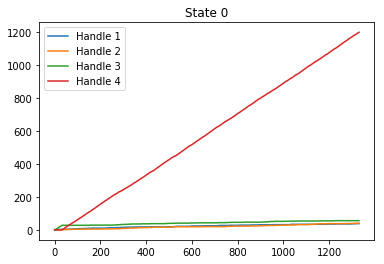

Final rewards [ -12   -5   -4 1197], total reward 1176


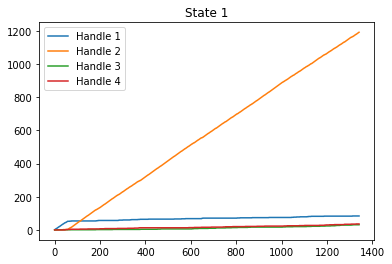

Final rewards [   4 1191  -19  -18], total reward 1158


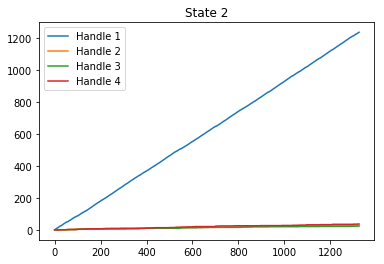

Final rewards [1235  -30  -24  -37], total reward 1144


In [73]:
for j in range(3):
    P = np.array(pulls)
    P = P[P[:,0] == j][:,1]
    for i in range(4):
        plt.plot(np.cumsum(P == i), label='Handle {0}'.format(i+1))
    plt.title('State {0}'.format(j))
    plt.legend()
    plt.show()
    print('Final rewards {0}, total reward {1}'.format(total_reward[j].astype('int'), total_reward[j].sum().astype('int')))